## Reproducing the subsampling analysis

In [1]:
import sys
sys.path.append('../')

from kgwas import KGWAS_Data
from kgwas.eval_utils import get_clumps_gold_label, get_meta_clumps, get_mega_clump_query, get_curve
from tqdm import tqdm
import pandas as pd
import numpy as np

data_path = '/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/'
data = KGWAS_Data(data_path = data_path)

All required data files are present.


In [2]:
data.get_pheno_list()['21_indep_traits']

['body_BALDING1',
 'disease_ALLERGY_ECZEMA_DIAGNOSED',
 'disease_HYPOTHYROIDISM_SELF_REP',
 'pigment_SUNBURN',
 '21001',
 '50',
 '30080',
 '30070',
 '30010',
 '30000',
 'biochemistry_AlkalinePhosphatase',
 'biochemistry_AspartateAminotransferase',
 'biochemistry_Cholesterol',
 'biochemistry_Creatinine',
 'biochemistry_IGF1',
 'biochemistry_Phosphate',
 'biochemistry_Testosterone_Male',
 'biochemistry_TotalBilirubin',
 'biochemistry_TotalProtein',
 'biochemistry_VitaminD',
 'bmd_HEEL_TSCOREz']

In [3]:
pd.read_csv(data_path + 'model_pred/subsample_results/body_BALDING1_seed1.csv')

,SNP,Full_Cohort_GWAS_P,Subsample_GWAS_P,KGWAS_P,FINDOR_P
0,rs3131962,0.784760,0.849006,2.064486,0.649200
1,rs12562034,0.193592,0.818576,1.990491,1.015493
2,rs4040617,0.918404,0.682007,1.658403,0.204787
3,rs79373928,0.131349,0.842476,1.681445,1.015493
4,rs11240779,0.172345,0.731189,1.777996,0.164688
...,...,...,...,...,...
536541,rs73174435,0.203959,0.279072,0.678606,1.015493
536542,rs3810648,0.192116,0.983950,2.392622,1.015493
536543,rs5771002,0.826494,0.441110,0.262227,1.015493
536544,rs3865764,0.413994,0.406396,1.481344,0.110274


In [4]:
frac_list = [1000, 2500, 5000, 7500, 10000]
snp_info = pd.read_csv(data_path + 'misc_data/snp_qc_info.csv')
t_p = 5e-8
seed_res = {}
for seed in [1,2,3,4,5]:
    def get_res(query_disease):
        df_data = pd.read_csv(data_path + f'model_pred/subsample_results/{query_disease}_seed{seed}.csv')
        df_data = snp_info.merge(df_data)
        
        frac2res_all = {}    
        for frac in tqdm(frac_list):
            frac2res_frac = {}
            gold_label_gwas = df_data[['SNP', 'CHR', 'Full_Cohort_GWAS_P']].rename(columns = {'Full_Cohort_GWAS_P': 'P'})
            base_gwas = df_data[['SNP', 'CHR', 'Subsample_GWAS_P']].rename(columns = {'Subsample_GWAS_P': 'P'})
            kgwas = df_data[['SNP', 'CHR', 'KGWAS_P']].rename(columns = {'KGWAS_P': 'P'})
            findor = df_data[['SNP', 'CHR', 'FINDOR_P']].rename(columns = {'FINDOR_P': 'P'})

            gold_snps = gold_label_gwas[gold_label_gwas.P < t_p].SNP.values
            clumps = get_clumps_gold_label(data_path, gold_label_gwas, t_p = t_p, no_hla = True) 
            idx2mega_clump, idx2mega_clump_rsid, idx2mega_clump_chrom = get_meta_clumps(clumps, data_path) ## filtering cM
            mega_clump_gold = [j for i,j in idx2mega_clump_rsid.items()]
            
            def get_scores(base_gwas, name):
                frac2res = {}
                base_gwas['logp'] = -np.log10(base_gwas['P'])
                snp2rank = dict(base_gwas[['SNP', 'logp']].values)
                snp_hits = base_gwas.sort_values('P').SNP.values

                idx2mega_clump_pred, idx2mega_clump_rsid_pred, idx2mega_clump_chrom_pred = get_mega_clump_query(data_path, clumps, snp_hits, no_hla = True) 
                idx2mega_clump_rank_pred = {i: max([snp2rank[x] for x in j  if x in snp2rank]) for i,j in idx2mega_clump_rsid_pred.items()}
                idx2mega_clump_rank_pred = dict(sorted(idx2mega_clump_rank_pred.items(), key=lambda item: item[1])[::-1]) ## rank based on logp
                mega_clump_pred = [idx2mega_clump_rsid_pred[i] for i in list(idx2mega_clump_rank_pred.keys())][:1000] ## top 1000 predicted clumps
                frac2res['recall_k_base_gwas'], frac2res['precision_k_base_gwas'], frac2res['k_to_clump_idx_base_gwas'] = get_curve(mega_clump_pred, mega_clump_gold)
                frac2res['mega_clump_pred_base_gwas'] = mega_clump_pred
                frac2res['mega_clump_gold'] = mega_clump_gold

                rs_to_p = dict(base_gwas[['SNP', 'P']].values)
                mega_clump_sign = []
                for idx, mega_clump in enumerate(mega_clump_pred):
                    if min([rs_to_p[rs] for rs in mega_clump]) <= 5e-8:
                        ## is significant givent this threshold
                        mega_clump_sign.append(idx)

                mega_clump_sign_rep = []
                for idx in mega_clump_sign:
                    if len(np.intersect1d(mega_clump_pred[idx], gold_snps)) > 0:
                        mega_clump_sign_rep.append(idx)
                frac2res['num_significant_' + str(5e-8) +'_' + name] = len(mega_clump_sign)
                frac2res['num_significant_replicated_' + str(5e-8) + '_' + name] = len(mega_clump_sign_rep)
                return frac2res

            frac2res_frac['gwas'] = get_scores(base_gwas, 'gwas')
            frac2res_frac['kgwas'] = get_scores(kgwas, 'kgwas')
            frac2res_frac['findor'] = get_scores(findor, 'findor')
            frac2res_all[frac] = frac2res_frac
        return frac2res_all
    import multiprocessing
    pheno_list = data.get_pheno_list()['21_indep_traits']
    with multiprocessing.Pool(len(pheno_list)) as p:
        res = list(tqdm(p.imap(get_res, pheno_list), total=len(pheno_list)))
    frac2res_all = dict(zip(pheno_list, res))
    seed_res[seed] = frac2res_all

  0%|          | 0/5 [00:00<?, ?it/s]]/dfs/user/kexinh/miniconda3/envs/a100_env/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|          | 0/21 [04:09<?, ?it/s]


KeyboardInterrupt: 

In [10]:
method_list = ['gwas', 'findor', 'kgwas']

df_res_across_frac = pd.DataFrame()
df_res_per_disease = pd.DataFrame()

for frac in frac_list:
    df_res_all = pd.DataFrame()
    for seed in range(1,6):
        frac2res_all = seed_res[seed]
        res_threshold = []

        for query_disease in frac2res_all.keys():
            threshold = 5e-8
            for m in method_list:
                num = frac2res_all[query_disease][frac][m]['num_significant_replicated_' + str(threshold) + '_' + m]
                res_threshold.append((query_disease, frac, num, threshold, m.upper(), query_disease))

        df_res = pd.DataFrame(res_threshold).rename(columns = {0: 'Trait', 1: 'Frac', 2: '# of hits', 3: 'Threshold', 4: 'Method', 5: 'Trait'})
        df_res['seed'] = seed
        df_res_all = df_res_all.append(df_res)
        
    df_res_all.Threshold = df_res_all.Threshold.astype(str)
    df_res_per_disease = df_res_per_disease.append(df_res_all)
    df_res_temp = df_res_all[(df_res_all.Frac == frac) & (df_res_all.Threshold.isin(['5e-08']))]
    df_sum = pd.DataFrame(df_res_temp.groupby(['Method', 'Threshold', 'seed'])['# of hits'].agg(sum)).reset_index()
    
    df_sum['sample size'] = frac
    df_res_across_frac = df_res_across_frac.append(df_sum)

In [11]:
df_res_across_frac

,Method,Threshold,seed,# of hits,sample size
0,FINDOR,5e-08,1,59,1000
1,FINDOR,5e-08,2,57,1000
2,FINDOR,5e-08,3,55,1000
3,FINDOR,5e-08,4,59,1000
4,FINDOR,5e-08,5,63,1000
...,...,...,...,...,...
10,KGWAS,5e-08,1,73,10000
11,KGWAS,5e-08,2,78,10000
12,KGWAS,5e-08,3,70,10000
13,KGWAS,5e-08,4,73,10000


In [ ]:
id2name_longer = {
    'biochemistry_AlkalinePhosphatase': 'Alk_Phosphatase',
    'biochemistry_AspartateAminotransferase': 'Asp_Aminotrans',
    'biochemistry_Cholesterol': 'Cholesterol',
    'biochemistry_Creatinine': 'Creatinine',
    'biochemistry_IGF1': 'IGF-1',
    'biochemistry_Phosphate': 'Phosphate',
    'biochemistry_Testosterone_Male': 'Testosterone',
    'biochemistry_TotalBilirubin': 'Total_Bilirubin',
    'biochemistry_TotalProtein': 'Total_Protein',
    'biochemistry_VitaminD': 'Vitamin_D',
    'bmd_HEEL_TSCOREz': 'BMD_Heel_TScore',
    'body_BALDING1': 'Balding',
    'disease_ALLERGY_ECZEMA_DIAGNOSED': 'Allergy_Eczema',
    'disease_HYPOTHYROIDISM_SELF_REP': 'Hypothyroidism',
    'pigment_SUNBURN': 'Sunburn',
    '2714': 'Mineral_Needs',
    '21001': 'Body_Mass_Index',
    '50': 'Height',
    '30080': 'Platelet_Count',
    '30070': 'Red_Cell_Width',
    '30010': 'Red_Blood_Cell',
    '30000': 'White_Blood_Cell'
}


id2name = {
   'biochemistry_AlkalinePhosphatase': 'ALP',
   'biochemistry_AspartateAminotransferase': 'ALT',
   'biochemistry_Cholesterol': 'TC', 
   'biochemistry_Creatinine': 'CR',
   'biochemistry_IGF1': 'IGF1', 
   'biochemistry_Phosphate': 'PHO',
   'biochemistry_Testosterone_Male': 'TST', 
   'biochemistry_TotalBilirubin': 'TBIL',
   'biochemistry_TotalProtein': 'TP',
   'biochemistry_VitaminD': 'VD',
   'bmd_HEEL_TSCOREz': 'BMD-HT',
    'body_BALDING1': 'BALD',
    'disease_ALLERGY_ECZEMA_DIAGNOSED': 'Eczema',
    'disease_HYPOTHYROIDISM_SELF_REP': 'HT', 
    'pigment_SUNBURN': 'SUN', 
    '2714':'MNR', 
    '21001': 'BMI', 
    '50': 'Height', 
    '30080':'PLT', 
    '30070': 'RDW', 
    '30010': 'RBC', 
    '30000': 'WBC'
}

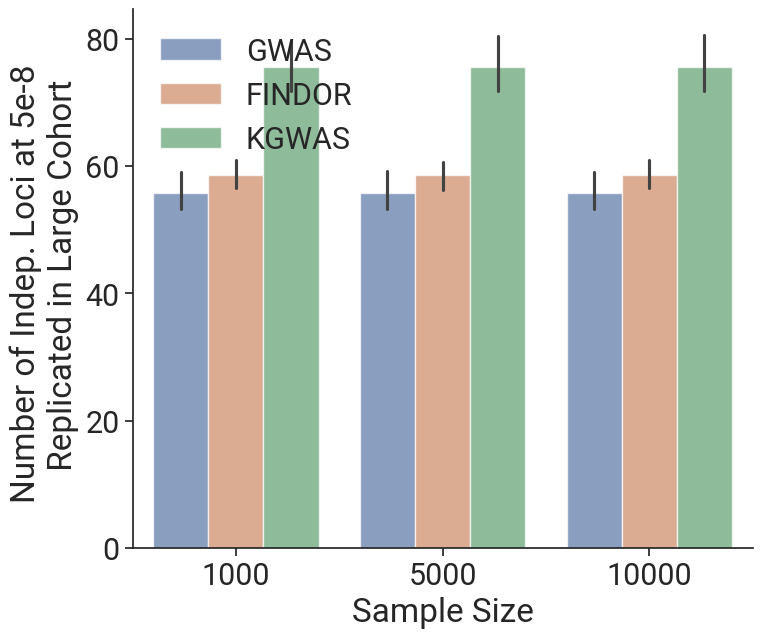

In [22]:
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt
from tqdm import tqdm

font_dirs = ["/dfs/project/datasets/20220524-ukbiobank/data/kgwas_data/misc_data/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set(rc={'figure.figsize':(8,7)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Roboto", font_scale=2)
plt.rc('axes', unicode_minus=False)

df_res_across_frac = df_res_across_frac.sort_values('# of hits')
ax = sns.barplot(data = df_res_across_frac[df_res_across_frac['sample size'].isin([1000, 5000, 10000])], x = 'sample size', y = '# of hits', 
                 hue = 'Method', hue_order = ['GWAS', 'FINDOR', 'KGWAS'], alpha = 0.7)
ax.set(ylabel = 'Number of Indep. Loci at 5e-8 \n Replicated in Large Cohort', xlabel = 'Sample Size')
legend = plt.legend(frameon=False, loc = 'upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
sns.despine()
plt.show()

In [ ]:

def plot_topk(frac2res_all, query_disease, k = None):
    k_gold = len(seed_res[1][query_disease][1000]['gwas']['mega_clump_gold'])
    df_plot_across_frac = []
    metric = '#Indep. Loci@K, K=' + str(k)
    for frac in frac_list:
        ratio = str(frac)
        for method in method_list:
            try:
                df_plot_across_frac.append((suffix2name[method], frac2res_all[frac]['recall_k' + method][k] * k_gold, ratio))
            except:
                print(frac)
                print(query_disease)
                print(frac2res_all[frac]['recall_k' + method].keys())
        
    df_plot_across_frac = pd.DataFrame(df_plot_across_frac).rename(columns = {0: 'Method', 1: metric, 2: 'Sampling Ratio'})
    
    return df_plot_across_frac

def plot_pr_paper(query_disease, frac, frac2res_all):
    frac2res = frac2res_all[query_disease][frac]

    def flatten(l):
        return [item for sublist in l for item in sublist]
    df_recall_at_prec = []
    mega_clump_gold = frac2res['mega_clump_gold']

    for prec in np.arange(0, 1.01, 0.01):
        recall_at_prec_frac = {}

        for method in method_list:

            prec_k_list = [i for i,j in frac2res['precision_k' + method].items() if j >= prec]
            if len(prec_k_list) > 0:
                recall_at_prec_frac[suffix2name[method]] = len([mega_clump_gold[i] for i in frac2res['k_to_clump_idx' + method][max(prec_k_list)]])
            else:
                recall_at_prec_frac[suffix2name[method]] = 0


        for x in [suffix2name[i] for i in method_list]:
            df_recall_at_prec.append((prec, x, recall_at_prec_frac[x]))

    df_recall_at_prec = pd.DataFrame(df_recall_at_prec).rename(columns = {0: 'Precision', 1: 'method', 2: '# of Indep Loci Found'})

    #df_recall_at_prec = df_recall_at_prec[df_recall_at_prec.method!='findor']
    to_report = df_recall_at_prec[df_recall_at_prec.Precision >= 0.2]
    ax = sns.lineplot(data = to_report, x = 'Precision', y='# of Indep Loci Found', 
                      hue = 'method', style='method', hue_order = method_name, markers=True)
    ax.set(title = id2name[query_disease], xlabel = 'Replication Rate of Retrieved Indep. Loci', ylabel = '# Indep. Loci Replicated at Large Cohort')
    legend = plt.legend(frameon=False, loc = 'upper right')
    #plt.legend([],[], frameon=False)
    frame = legend.get_frame()
    sns.despine()
    frame.set_facecolor('white')
    plt.show()